In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd


In [2]:
# Read australia region data
region = 'WA'
path = os.path.join('../data_library/covid_australia/', '{}.csv'.format(region))
data = pd.read_csv(path)

In [3]:
time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

# Pad with zeros the time points where we have no information on
# the number of incidences
padded_inc_data = data.set_index(time_key).reindex(
    range(
        1, max(data_times)+1)
        ).fillna(0).reset_index()
locally_infected_cases = padded_inc_data['Incidence Number']
imported_cases = padded_inc_data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

In [4]:
# Read serial interval
si_file = 'si-epinow'
path = os.path.join("../data_library/serial_interval", "{}.csv".format(si_file))
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)


In [5]:
serial_intervals = serial_interval.values.T

In [6]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=locally_infected_cases,
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=imported_cases,
        name='Imported Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

In [7]:
# Same inference, but using the LocImpBranchProPosterior
tau = 2
R_t_start = tau+1
a = 1
b = 0.8

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases
    }
)

epsilon = 0
inference = branchpro.LocImpBranchProPosteriorMultSI(
    inc_data=inc_data,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon,
    daily_serial_intervals=serial_intervals,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

Text(0.5, 1.0, 'Inferred effective reproduction number vs. time')

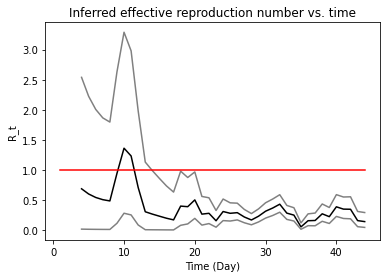

In [8]:
fig = plt.figure()
plt.plot(start_times[R_t_start:], intervals['Mean'], 'k')
plt.plot(start_times[R_t_start:], intervals['Lower bound CI'], 'gray')
plt.plot(start_times[R_t_start:], intervals['Upper bound CI'], 'gray')
plt.plot(start_times, np.ones(start_times.shape), 'red')
plt.xlabel('Time (Day)')
plt.ylabel('R_t')
plt.title('Inferred effective reproduction number vs. time')